# Прогнозирование оттока клиентов оператора связи

# Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии. 

Во всех файлах столбец customerID содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.

## Задачи проекта

Нам нужно:
* Загрузить и обработать данные
* Провести исследовательский анализ 
* Построить, обучить и проверить несколько моделей машинного обучения для прогнозирования оттока клиентов и выбрать лучшую с помощью кросс-валидации
* По результатам предыдущего пункта, нашей лучшей модели **необходимо достичь минимального порога метрики AUC-ROC в 0.85** и выше 
* Написать выводы

В ячейке ниже загрузим все необходимые библиотеки для выполнения проекта и будем её дополнять по мере необходимости.

In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.ensemble import RandomForestClassifier 
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix
)

pd.set_option('display.max_columns', None)
from time import time

C:\Users\Games\AppData\Local\Temp\ipykernel_34184\2480194207.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# помним про PEP-8
# импорты из стандартной библиотеки
import warnings

In [3]:
# настройки
warnings.filterwarnings("ignore")

In [4]:
display(HTML("<style>.container { width:88% !important; }</style>"))

В след. ячейке определим константы.

In [5]:
RANDOM_STATE = 250923
CV = 5 
ITERATIONS = 100
VERBOSE = 1
NJOBS = -1

Загрузим наши датасеты.

In [6]:
try:
    forsenc = pd.read_csv('/kaggle/input/telecom-churn/contract_new.csv')
except:
    forsenc = pd.read_csv('C:/Users/Games/Downloads/contract_new.csv')

In [7]:
try:
    forsenpe = pd.read_csv('/kaggle/input/telecom-churn/personal_new.csv')
except:
    forsenpe = pd.read_csv('C:/Users/Games/Downloads/personal_new.csv')

In [8]:
try:
    forsenph = pd.read_csv('/kaggle/input/telecom-churn/phone_new.csv')
except:
    forsenph = pd.read_csv('C:/Users/Games/Downloads/phone_new.csv')

In [9]:
try:
    forseni = pd.read_csv('/kaggle/input/telecom-churn/internet_new.csv')
except:
    forseni = pd.read_csv('C:/Users/Games/Downloads/internet_new.csv')

Напишем функцию, которая будет обрабатывать определённый датасет и выводить первичную необходимую информацию о нём.

In [10]:
def information(dataframe):
    rows_count, columns_count = dataframe.shape
    print('Количество столбцов:', columns_count)
    print('Количество строк:', rows_count)
    data_info = display(dataframe.info())
    data_head = display(dataframe.head())
    data_desc = display(dataframe.describe())
    return data_info, data_head, data_desc

Перейдём к исследовательскому анализу данных.

In [11]:
information(forsenc)

Количество столбцов: 8
Количество строк: 7043
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


(None, None, None)

In [12]:
forsenc['customerID'].value_counts()

7534-BFESC    1
4837-PZTIC    1
0581-BXBUB    1
4182-BGSIQ    1
6927-WTFIV    1
             ..
7402-PWYJJ    1
6754-LZUKA    1
9891-NQDBD    1
4412-YLTKF    1
8336-TAVKX    1
Name: customerID, Length: 7043, dtype: int64

In [13]:
display(forsenc['EndDate'].value_counts())

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-09-01       2
2014-11-01       1
2014-06-01       1
2014-10-01       1
Name: EndDate, Length: 67, dtype: int64

In [14]:
display(forsenc['Type'].unique())

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [15]:
display(forsenc['PaperlessBilling'].unique())

array(['Yes', 'No'], dtype=object)

In [16]:
display(forsenc['PaymentMethod'].unique())

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Всего 7043 строки, пропуски отсутствуют.  
В датафрейме есть 2 столбца с датами (BeginDate & EndDate), но тип данных несоответствующий. Один из них "EndDate" является будущим целевым признаком для построения модели и определения факторов прекращения действия договора (уход клиента).  
Потом нужно будет преобразовать как названия столбцов, так и сам столбец с целевым признаком.  В столбце TotalCharges неверный тип данных, нужно будет его изменить на float, т.к. значения нецелочисленные.

Перейдем ко второму датасету.

In [17]:
information(forsenpe)

Количество столбцов: 5
Количество строк: 7043
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


(None, None, None)

In [18]:
forsenpe['customerID'].value_counts()

7534-BFESC    1
4837-PZTIC    1
0581-BXBUB    1
4182-BGSIQ    1
6927-WTFIV    1
             ..
7402-PWYJJ    1
6754-LZUKA    1
9891-NQDBD    1
4412-YLTKF    1
8336-TAVKX    1
Name: customerID, Length: 7043, dtype: int64

In [19]:
forsenpe['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

Всего 7043 строки, столько же, сколько и в первом датасете. Пропуски отсутствуют.  
Все столбцы, кроме ID, бинарная классификация. 

Перейдём к третьему датасету.

In [20]:
information(forsenph)

Количество столбцов: 2
Количество строк: 6361
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7534-BFESC,No
freq,1,3390


(None, None, None)

Общее кол-во строк - 6361, меньше, чем в двух предыдущих датасетах, пропуски отсутствуют.  
Значит данные есть не по всем клиентам.  
Очередной признак бинарной классификации. 

Перейдём к последнему - четвёртому датасету.

In [21]:
information(forseni)

Количество столбцов: 8
Количество строк: 5517
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5055-MGMGF,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


(None, None, None)

В этом датасете наименьшее кол-во строк из всех - 5517, ещё больше отсутствующих данных по клиентам. Пропуски отсутствуют.  
Все потенциальные признаки для будущей модельной выборки - бинарная классификация, кроме "InternetService", ибо в нём содержится информация по типу технологии подключения, в будущем компания может добавить дополнительные опции, следовательно при дальнейшем анализе/обработке нужно будет это учитывать.  

Во всех датафреймах уникальные ID клиентов. В первых двух (personal & contract) они совпадают по кол-ву.

Переименуем названия столбцов в датасетах и заодно приведём их полностью к нижнему регистру.

In [22]:
forsenc = forsenc.rename(columns={'customerID': 'customer_id', 'BeginDate': 'begin_date', 'EndDate': 'end_date', 'Type': 'type', 'PaperlessBilling': 'paperless_billing', 'PaymentMethod': 'payment_method',
                                 'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges'})
print(forsenc.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


In [23]:
forsenpe = forsenpe.rename(columns={'customerID': 'customer_id', 'SeniorCitizen': 'senior_citizen'})
forsenpe.columns = forsenpe.columns.str.lower()
print(forsenpe.columns)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


In [24]:
forsenph = forsenph.rename(columns={'customerID': 'customer_id', 'MultipleLines': 'multiple_lines'})
print(forsenph.columns)

Index(['customer_id', 'multiple_lines'], dtype='object')


In [25]:
forseni = forseni.rename(columns={'customerID': 'customer_id', 'InternetService': 'internet_service', 'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup', 'DeviceProtection': 'device_protection', 'TechSupport': 'tech_support',
                                 'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies'})
print(forseni.columns)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


Сначала на основе столбца "end_date" добавим доп. столбец "churn" с целевым признаком, который будет означать отказался клиент от услуг или нет, затем поменяем типы данных в нужных столбцах.

In [26]:
forsenc['churn'] = (forsenc['end_date'] != 'No').astype(int)
forsenc.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


Если значение в столбце EndDate равно "No", то значит клиент не ушел и целевой признак равен 0 и наоборот.

Заменим все значения "No" на последнюю актуальную дату - 01.02.2020 и конвертируем тип данных.

In [27]:
forsenc['end_date'] = forsenc['end_date'].replace('No', '2020-02-01') 
forsenc['end_date'] = pd.to_datetime(forsenc['end_date'], format='%Y-%m-%d')
forsenc['begin_date'] = pd.to_datetime(forsenc['begin_date'], format='%Y-%m-%d')
forsenc['total_charges'] = pd.to_numeric(forsenc['total_charges'], errors='coerce')

In [28]:
forsenc.info()
forsenc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   churn              7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0


Сразу заметим, что в столбце TotalCharges появились пропуски, посмотрим на строки с ними.

In [29]:
forsenc[forsenc['total_charges'].isnull()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0


Заметим, что эти клиенты заключили договора в день выгрузки датасета, поэтому можем безболезненно заменить пропущенные значения нулём. 

In [30]:
forsenc['total_charges'] = forsenc['total_charges'].fillna(0)

In [31]:
forsenc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB


Можем также добавить ещё 1 признак на основе того, как долго клиент пользовался услугами перед уходом в днях.

In [32]:
forsenc['days_total'] = (forsenc['end_date'] - forsenc['begin_date']).dt.days
forsenc.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,days_total
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


## План:

Нам необходимо предсказать уход клиента. Вероятность ухода клиента нужно оценить по вероятности принадлежности к одному из двух классов: действующий клиент / клиент с расторгнувшим договором.
Таким образом, решается задача классификации.

* Изучить данные в файлах - проверить типы, есть ли пропуски, надо ли преобразовывать данные;
* Подготовить данные на основе выводов, полученных на предыдущем шаге, объединить датасеты;
* Провести исследовательский анализ данных объединённого датасета - вузализация данных, избавление от выбросов, потенциальное удаление ненужных признаков
* Подготовить датасет к построению и обучению различных моделей: разделить объединённый датасет на выборки (обучающую и тестовую), кодирование и масштабирование признаков;
* Перебрать различные модели на кроссвалидации, выбрать лучшую, протестировать её, построить ROC-curve;
* Написать итоговый вывод по проекту;

Объединим датасеты в один.

In [33]:
forsenun = forsenc.merge(forsenpe, how='left', on='customer_id'). \
    merge(forsenph, how='left', on='customer_id'). \
    merge(forseni, how='left', on='customer_id') 

In [34]:
forsenun.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int32         
 9   days_total         7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  multiple

In [35]:
display(forsenun.head())

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,days_total,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [36]:
forsenun['customer_id'].value_counts()

7534-BFESC    1
4837-PZTIC    1
0581-BXBUB    1
4182-BGSIQ    1
6927-WTFIV    1
             ..
7402-PWYJJ    1
6754-LZUKA    1
9891-NQDBD    1
4412-YLTKF    1
8336-TAVKX    1
Name: customer_id, Length: 7043, dtype: int64

Проверили, что все значения айди юзеров уникальны (метод 'value_counts' возвращает уникальные значения по убыванию), теперь можем установить их как индексы датасета.

In [37]:
forsenun = forsenun.set_index('customer_id')

In [38]:
information(forsenun)

Количество столбцов: 21
Количество строк: 7043
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   churn              7043 non-null   int32         
 8   days_total         7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  multip

None

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,days_total,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


,monthly_charges,total_charges,churn,days_total,senior_citizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,898.555729,0.162147
std,30.090047,2112.742814,0.363189,683.130510,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000,0.000000
50%,70.350000,1343.350000,0.000000,761.000000,0.000000
75%,89.850000,3236.690000,0.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


(None, None, None)

Мы видим, что в объединённом датасете появились пропуски в столбцах, которые изначально были в последних двух датасетах: phone с информацией об услугах телефонии и internet с информацией о различных интернет услугах. Т.к. в этих датасетах меньше строк (меньше ID, меньше клиентов), то, скорее всего, логика такова, что эти услуги не были подключены. Поэтому, в столбцах, начиная с 'multiple_lines' и до конца 'streaming_movies' вполне можем заменить пропущенные значения на 'No'. Кроме столбца 'internet_service', т.к. в нём содержится информация по типу технологии подключения, в будущем компания может добавить дополнительные опции. В нём заменим просто на другое значение, например - 'unknown'.  

In [39]:
for column in ('multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'):
    forsenun[column] = forsenun[column].fillna('No')

In [40]:
forsenun['internet_service'] = forsenun['internet_service'].fillna('Unknown')

In [41]:
information(forsenun)

Количество столбцов: 21
Количество строк: 7043
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   churn              7043 non-null   int32         
 8   days_total         7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  multip

None

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,days_total,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


,monthly_charges,total_charges,churn,days_total,senior_citizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,898.555729,0.162147
std,30.090047,2112.742814,0.363189,683.130510,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000,0.000000
50%,70.350000,1343.350000,0.000000,761.000000,0.000000
75%,89.850000,3236.690000,0.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


(None, None, None)

Избавились от пропусков, перейдем к исследовательскому анализу данных объединённого датасета.

# Исследовательский анализ данных

Выделим категориальные признаки в отдельный список для анализа и будущего кодирования.

In [42]:
cat_features = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner','dependents',
                'internet_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection',
                'tech_support', 'streaming_tv', 'streaming_movies']
num_features = ['monthly_charges', 'total_charges', 'days_total']

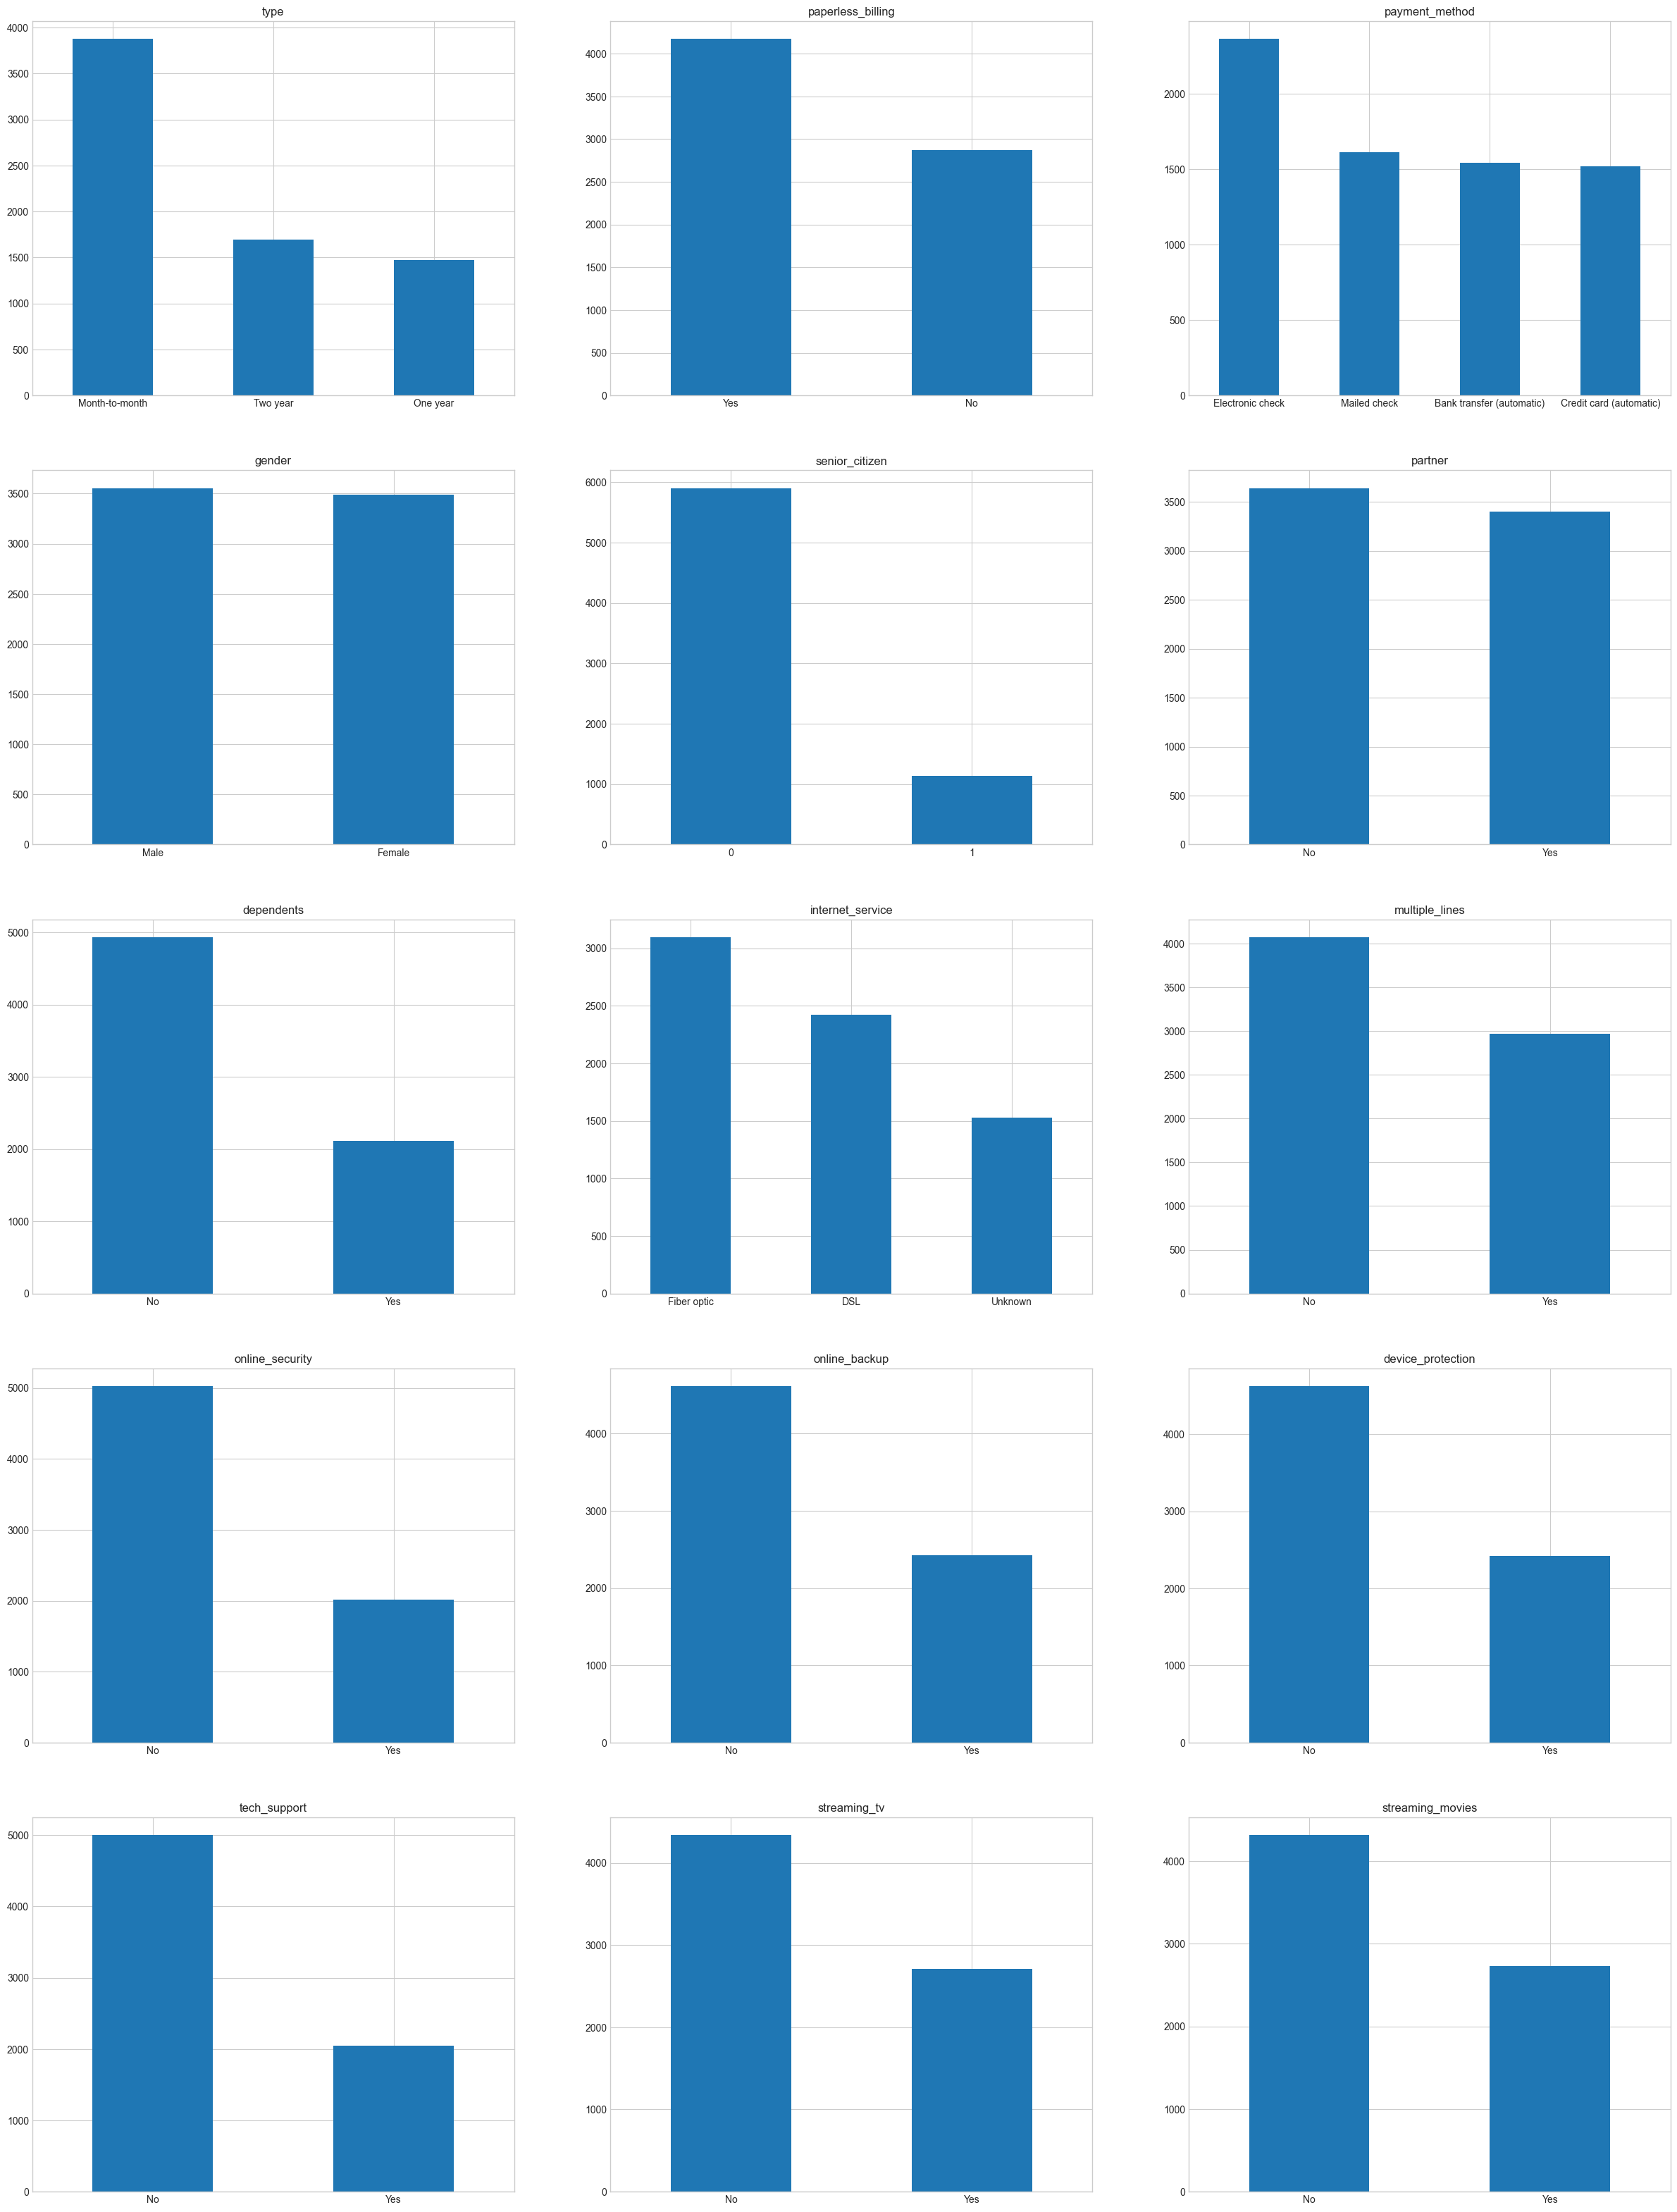

In [43]:
plt.style.use('seaborn-whitegrid')
rows = int(len(cat_features) / 3)
plt.figure(figsize=(30, 40))

for x, column in enumerate(cat_features):
    ax = plt.subplot(rows, 3, x + 1)
    
    forsenun[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0)
    plt.xlabel('')
 
plt.show()



* Ежемесячный способ оплаты самый популярный;
* Наиболее предпочтительный способ выставления счёта - электронный;
* Самый популярный способ оплаты - электронный чек;
* Самый частый способ подключения - оптоволокно;
* Распределение между полами - равное;
* Распределение замужних/холостых клиентов равное;
* Молодых клиентов подавляющее большинство;
* Соотношение клиентов с иждивенцами и без - 2/5;
* Все доп. услуги чаще всего не подключены более чем у половины клиентов, чаще всего доля подключённых клиентов к той или иной доп. услуге составляет одну треть;

Теперь сделаем тоже самое для количественных признаков + построим для них боксплоты.

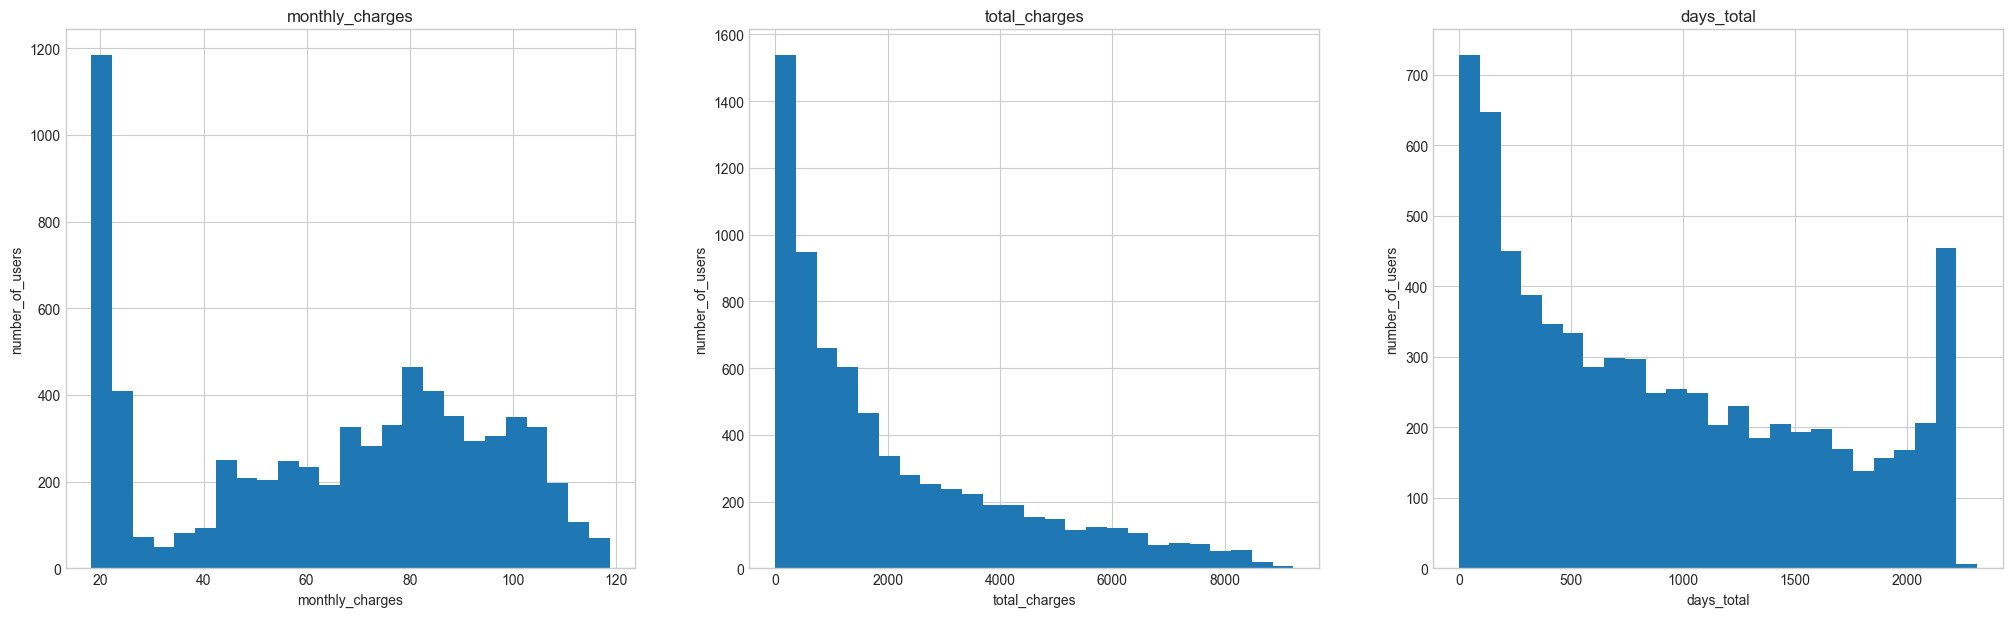

In [44]:
plt.style.use('seaborn-whitegrid')
rows = int(len(num_features) / 2)
plt.figure(figsize=(25, 7))

for x, column in enumerate(num_features):
    ax = plt.subplot(rows, 3, x + 1)
    
    forsenun[column].plot(
        ax=ax,
        kind = 'hist',
        bins=25,
        title=column)
    plt.xlabel(column)
    plt.ylabel('number_of_users')   
plt.show()

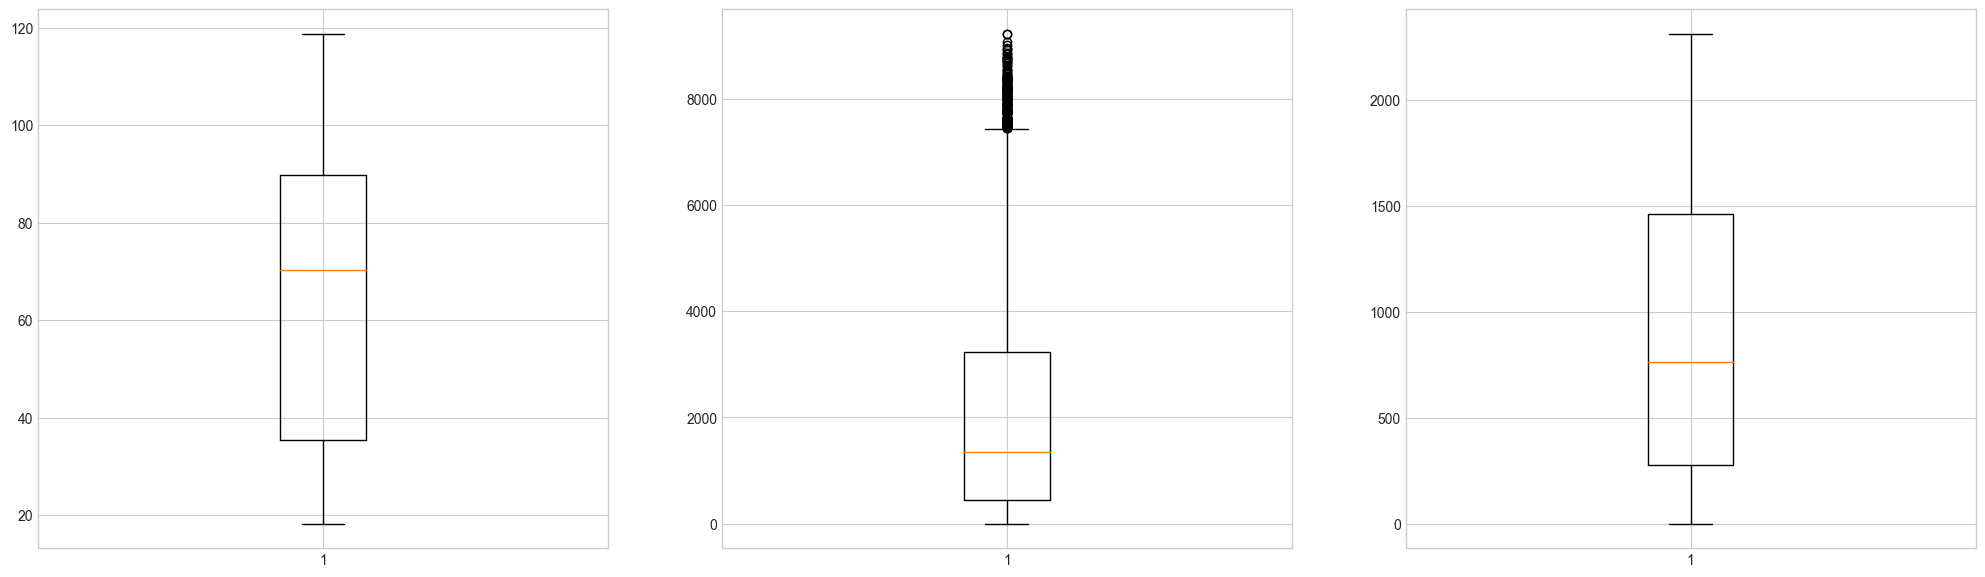

In [45]:
plt.style.use('seaborn-whitegrid')
rows = int(len(num_features) / 2)
plt.figure(figsize=(25, 7))

for x, column in enumerate(num_features):
    ax = plt.subplot(rows, 3, x + 1)
    
    plt.boxplot(forsenun[column])
    
plt.show()


In [46]:
forsenun.describe()

,monthly_charges,total_charges,churn,days_total,senior_citizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,898.555729,0.162147
std,30.090047,2112.742814,0.363189,683.130510,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000,0.000000
50%,70.350000,1343.350000,0.000000,761.000000,0.000000
75%,89.850000,3236.690000,0.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


На боксплоте 'total_charges' после примерно значения в 7300 видим выбросы, посмотрим сколько их и какой у них целевой признак.

In [47]:
vibrosi = forsenun.query('total_charges > 7300')
display(vibrosi)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,days_total,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,,,,,,,,,,,,,,,
9959-WOFKT,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),106.70,8257.51,0,2163,Male,0,No,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes
5067-XJQFU,2014-08-01,2020-02-01,One year,Yes,Electronic check,108.45,7730.32,0,2010,Male,1,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
5954-BDFSG,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),107.50,7740.00,0,2191,Female,0,No,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes
6728-DKUCO,2014-02-01,2020-02-01,One year,Yes,Electronic check,104.15,7498.80,0,2191,Female,0,Yes,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes
7255-SSFBC,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),112.25,8324.46,0,2191,Male,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8213-TAZPM,2014-05-01,2020-02-01,One year,Yes,Bank transfer (automatic),108.75,7728.86,0,2102,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
6257-DTAYD,2014-03-01,2020-02-01,Two year,Yes,Credit card (automatic),104.15,7394.65,0,2163,Male,0,Yes,No,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes
0218-QNVAS,2014-03-01,2020-02-01,One year,No,Bank transfer (automatic),100.55,7638.78,0,2163,Male,0,Yes,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes


In [48]:
display(vibrosi['churn'].value_counts())

0    216
1      4
Name: churn, dtype: int64

Посмотрим на баланс целевого признака.

[Text(0.5, 0, 'Значение'), Text(0, 0.5, 'Кол-во значений')]

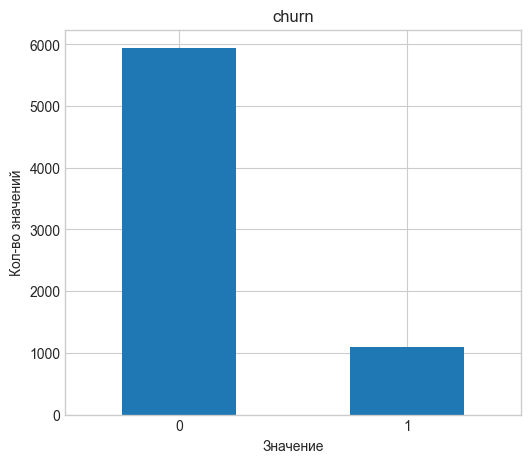

In [49]:
plt.figure(figsize=(20,5)) 
ax = plt.subplot(rows, 3, x + 1)
   
forsenun['churn'].value_counts().plot(
    kind='bar', 
    title='churn', 
    ax=ax,
    rot=0).set(xlabel='Значение', ylabel='Кол-во значений')


Такие высокие значения, отображённые на боксплоте выше, это просто давние клиенты компании. Это можно понять, если посмотреть на длительность каждого их контракта. Не будем считать их выбросами и удалять из датасета.

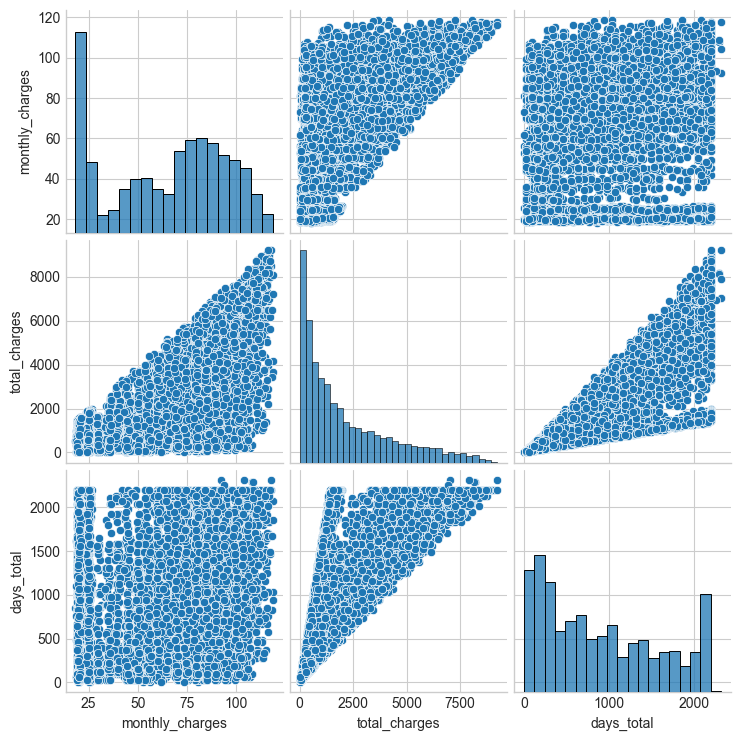

In [50]:
sns.pairplot(forsenun[num_features])

Наблюдается нелинейная связь между признаками.

Теперь посмотрим на разбивку признаков через призму целевого.

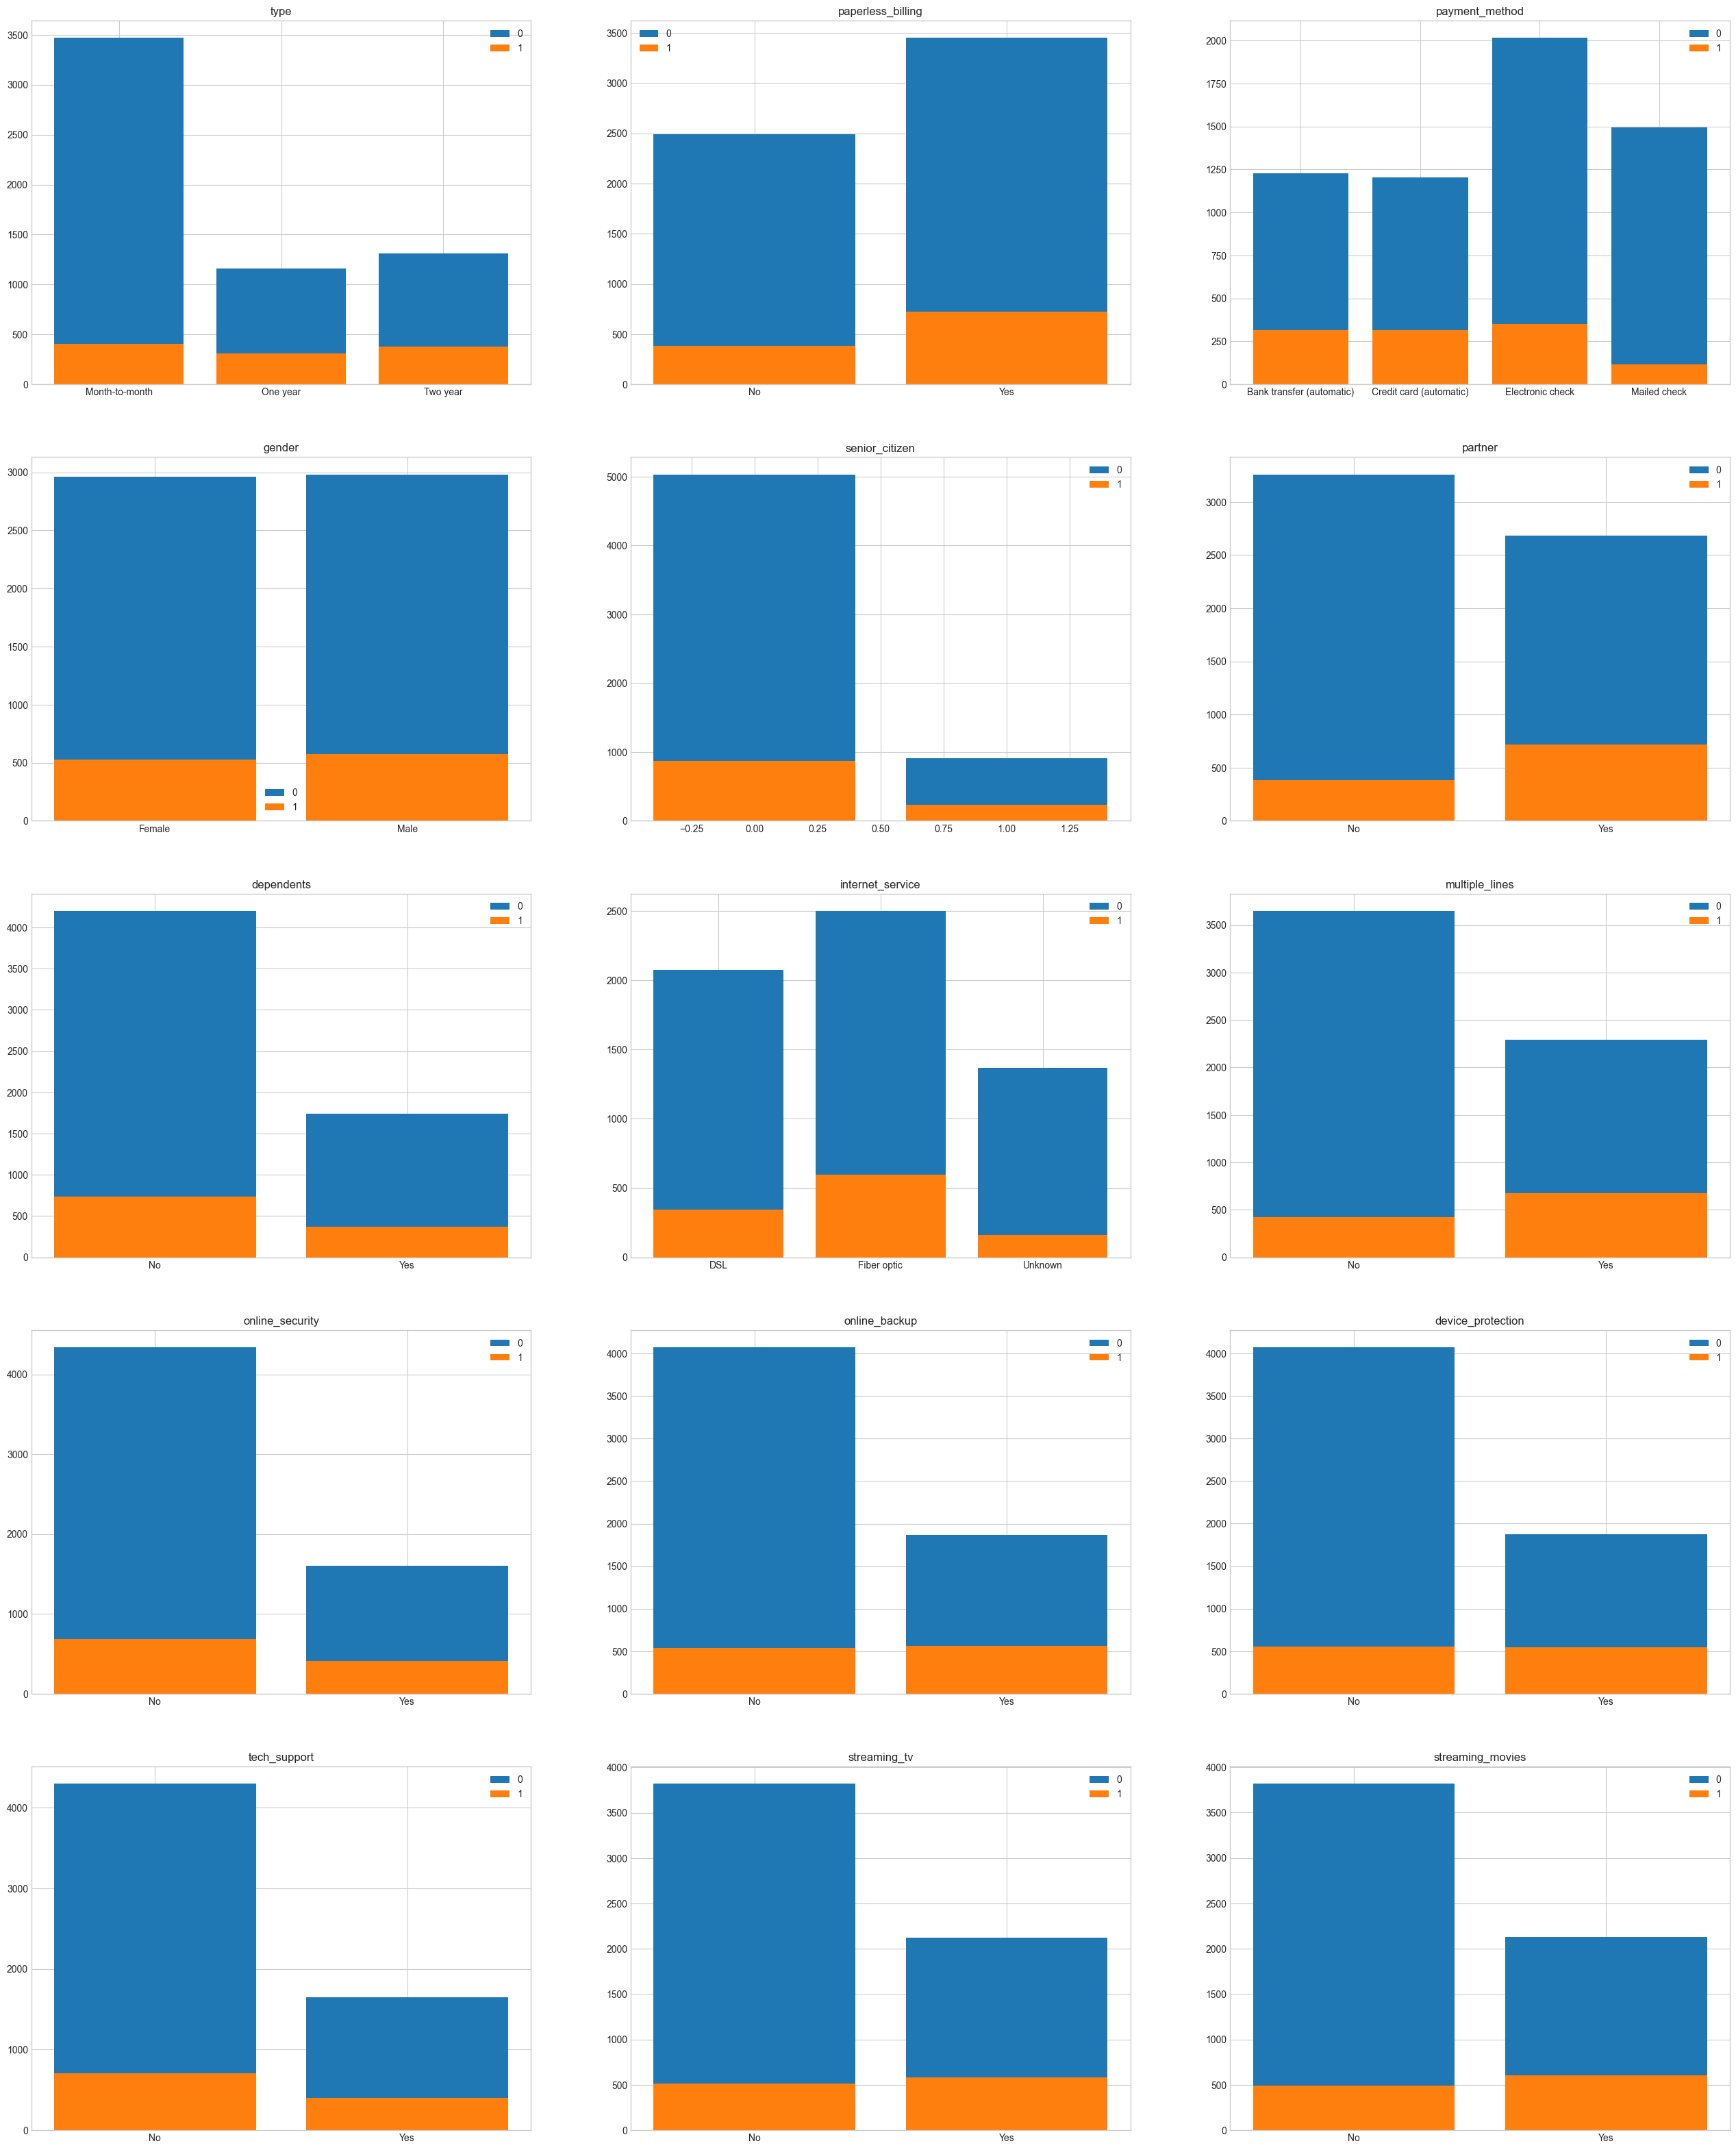

In [51]:
cols = 3
rows = int(len(cat_features) / 3)

plt.figure(figsize=(32, 40))

for x, column in enumerate(cat_features):
    churn_grouped_forsen = forsenun.groupby([column, 'churn'])['churn'].count()
    churn_grouped_forsen = churn_grouped_forsen.unstack()
    ax = plt.subplot(rows, cols, x + 1)

    ax.bar(churn_grouped_forsen.index, churn_grouped_forsen[churn_grouped_forsen.columns[0]], label=churn_grouped_forsen.columns[0])
    
    for value in churn_grouped_forsen.columns[1:]: 
        ax.bar(churn_grouped_forsen.index, churn_grouped_forsen[value], label=value)
    plt.title(column)
    plt.legend()
        
plt.show()

* Доля отказов среди клиентов с ежемесячной оплатой выше, чем среди тех, кто сразу платит за 1 или 2 года;
* Доля отказов в дополнительных услугах прим. одинакова и не выделяется у какой-то конкретной;
* Доля отказов клиентов, использующих электронную оплату, выше. Возможно, такой способ оплаты имеет какие-то недостатки;
* Доля отказов среди пенсионеров значительно меньше;
* Доля замужних людей среди отказов выше;
* Доля отказов среди тех, кто не подключил телефонию ниже;
* Доля людей, которые не подключены к интернету (предположительно значение 'unknown' в столбце 'internet_service');
* Отказ от услуг **не зависит** от половой принадлежности клиента;

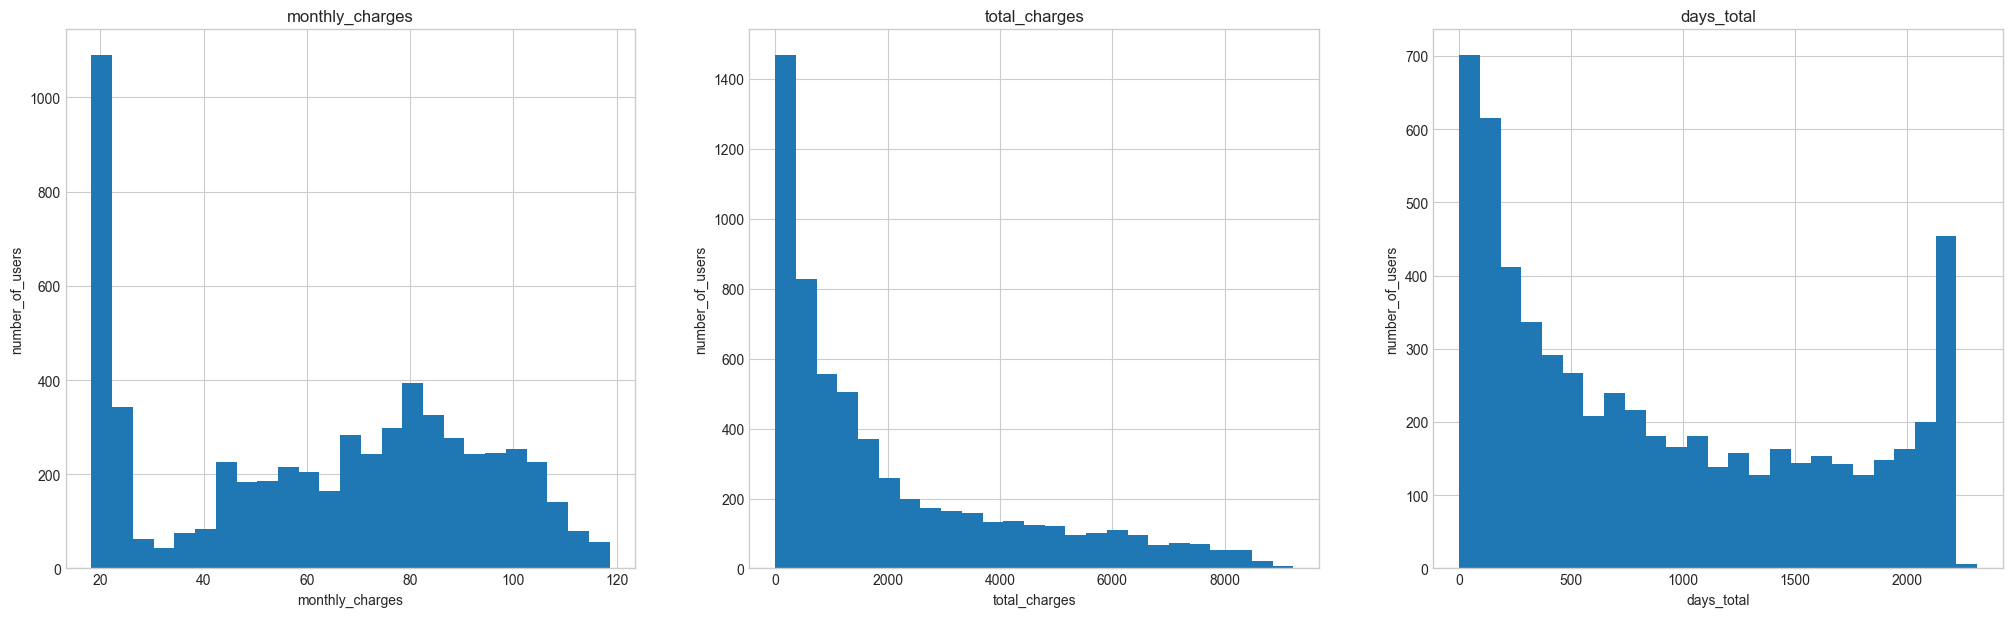

In [52]:
plt.style.use('seaborn-whitegrid')
rows = int(len(num_features) / 2)
plt.figure(figsize=(25, 7))

for x, column in enumerate(num_features):
    ax = plt.subplot(rows, 3, x + 1)
    
    forsenun[forsenun['churn']==0][column].plot(
        ax=ax,
        kind = 'hist',
        bins=25,
        title=column)
    plt.xlabel(column)
    plt.ylabel('number_of_users')   
plt.show()

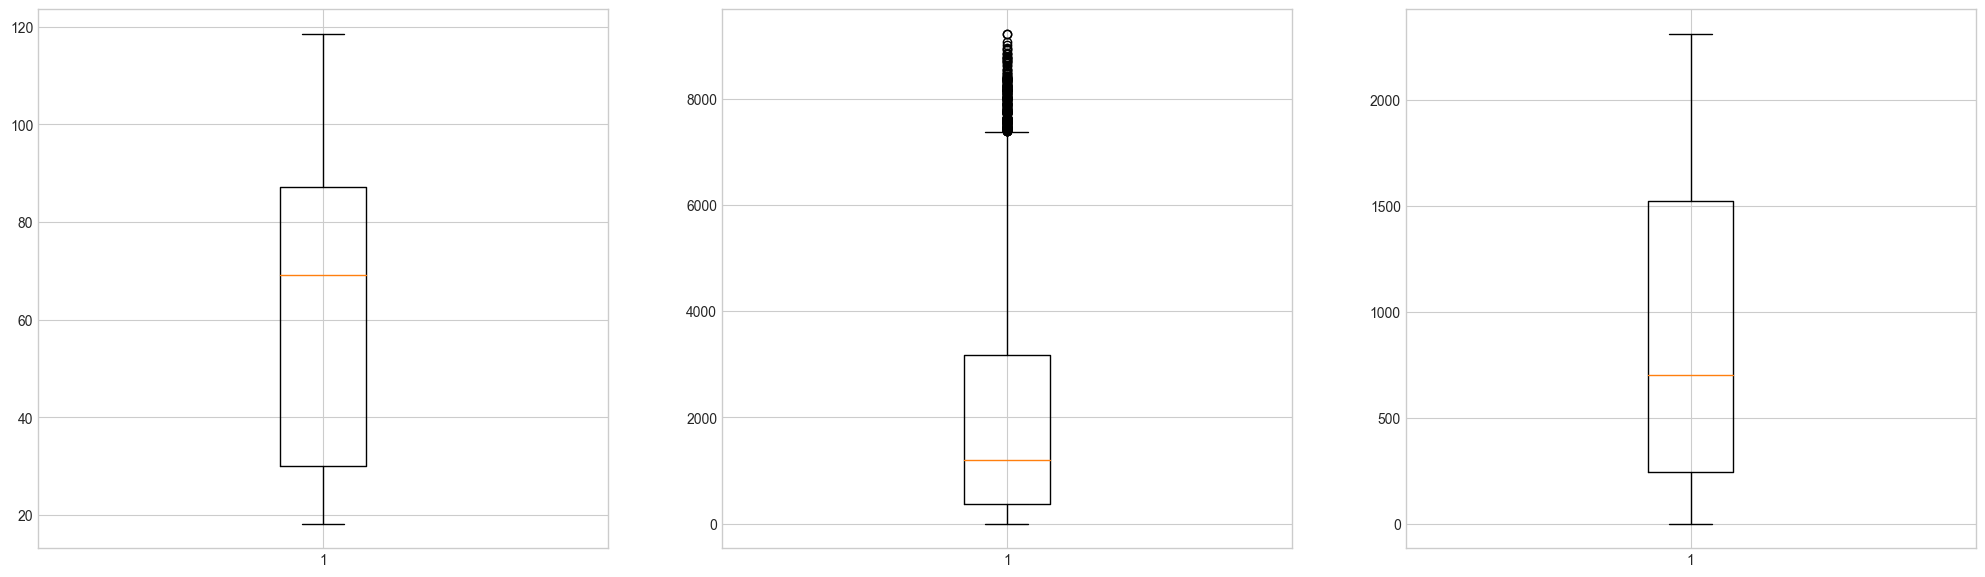

In [53]:
plt.style.use('seaborn-whitegrid')
rows = int(len(num_features) / 2)
plt.figure(figsize=(25, 7))

for x, column in enumerate(num_features):
    ax = plt.subplot(rows, 3, x + 1)
    
    plt.boxplot(forsenun[forsenun['churn']==0][column])
    
plt.show()

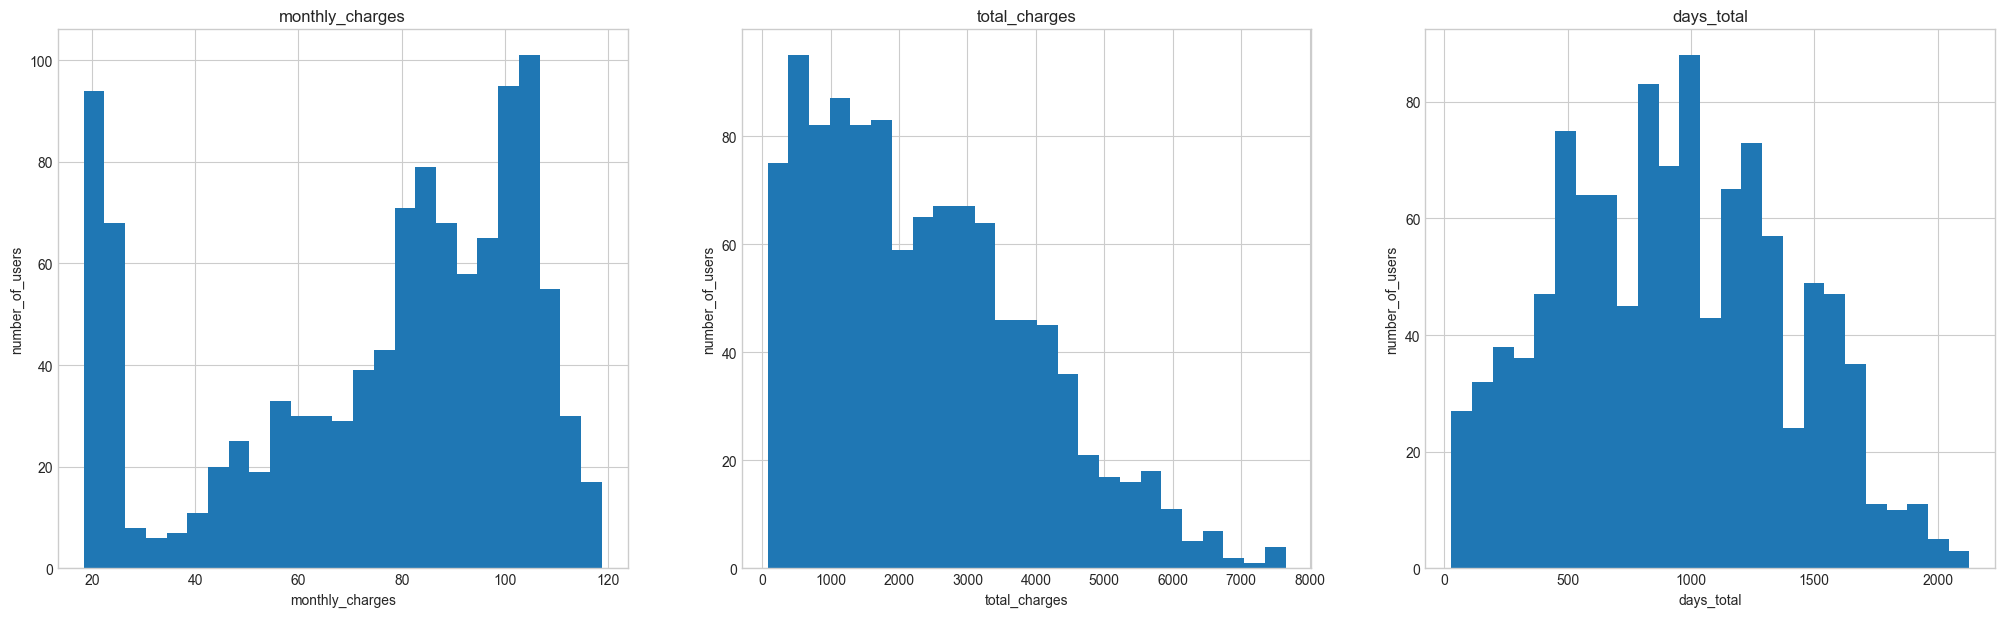

In [54]:
plt.style.use('seaborn-whitegrid')
rows = int(len(num_features) / 2)
plt.figure(figsize=(25, 7))

for x, column in enumerate(num_features):
    ax = plt.subplot(rows, 3, x + 1)
    
    forsenun[forsenun['churn']==1][column].plot(
        ax=ax,
        kind = 'hist',
        bins=25,
        title=column)
    plt.xlabel(column)
    plt.ylabel('number_of_users')   
plt.show()

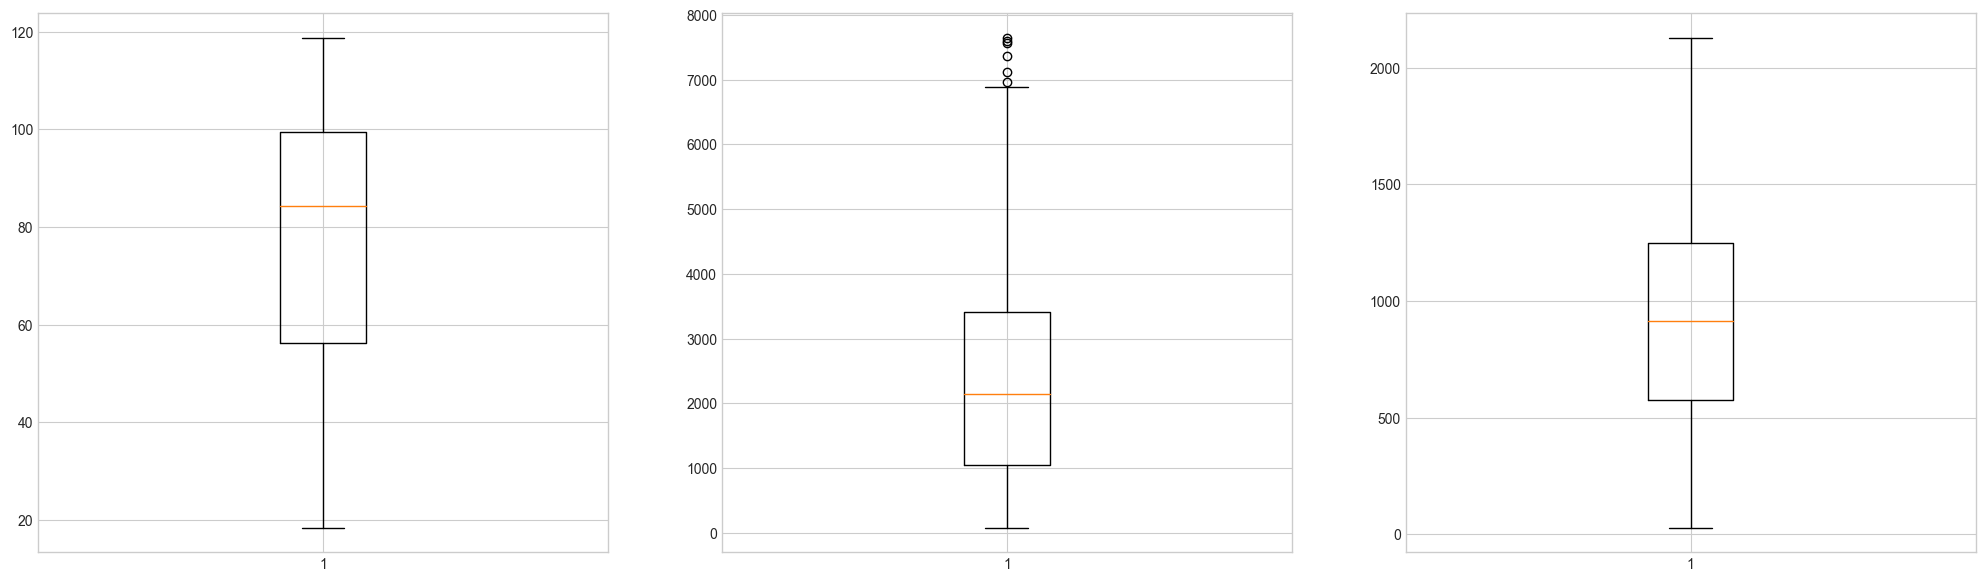

In [55]:
plt.style.use('seaborn-whitegrid')
rows = int(len(num_features) / 2)
plt.figure(figsize=(25, 7))

for x, column in enumerate(num_features):
    ax = plt.subplot(rows, 3, x + 1)
    
    plt.boxplot(forsenun[forsenun['churn']==1][column])
    
plt.show()

* Чем дольше клиент пользуется услугами, тем меньше вероятность отказа в будущем;
* Чем больше платит клиент, тем чаще он отказывается от услуг;
* Постоянные (долгие) клиенты платят меньше новых;

Теперь проведём корреляционный анализ.

Создадим для этого копию объединённого датасета и преобразуем в нём признаки с помощью 'ordinal_encoder' для замены типа столбцов на float/int с object. Также заранее уберём столбцы с датами.

In [56]:
forsenuncorr = forsenun.iloc[:,2:].copy()

In [57]:
forsenuncorr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   churn              7043 non-null   int32  
 6   days_total         7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  multiple_lines     7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support  

In [58]:
interval_cols = ['monthly_charges', 'total_charges', 'days_total']

In [59]:
forsenuncorr.phik_matrix(interval_cols = interval_cols)

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,days_total,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
type,1.000000,0.106860,0.277462,0.388444,0.470860,0.094015,0.634155,0.000000,0.086231,0.179736,0.147680,0.065498,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608
paperless_billing,0.106860,1.000000,0.370495,0.467812,0.201703,0.083398,0.026799,0.000000,0.242133,0.013218,0.172593,0.252972,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551
payment_method,0.277462,0.370495,1.000000,0.399526,0.335666,0.214832,0.350964,0.000000,0.292725,0.243008,0.224903,0.339313,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907
monthly_charges,0.388444,0.467812,0.399526,1.000000,0.710905,0.226280,0.387727,0.008175,0.304985,0.203545,0.184366,0.675883,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307
total_charges,0.470860,0.201703,0.335666,0.710905,1.000000,0.302890,0.848337,0.000000,0.135650,0.381958,0.084247,0.573191,0.490081,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210
churn,0.094015,0.083398,0.214832,0.226280,0.302890,1.000000,0.374569,0.008581,0.086159,0.226688,0.046871,0.261237,0.056621,0.132594,0.229482,0.218380,0.103652,0.200198,0.222232
days_total,0.634155,0.026799,0.350964,0.387727,0.848337,0.374569,1.000000,0.000000,0.063315,0.453688,0.198729,0.398222,0.060845,0.395693,0.414982,0.426931,0.404795,0.339313,0.339313
gender,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000
senior_citizen,0.086231,0.242133,0.292725,0.304985,0.135650,0.086159,0.063315,0.000000,1.000000,0.016992,0.324576,0.221313,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141
partner,0.179736,0.013218,0.243008,0.203545,0.381958,0.226688,0.453688,0.000000,0.016992,1.000000,0.652122,0.220101,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011


<AxesSubplot:>

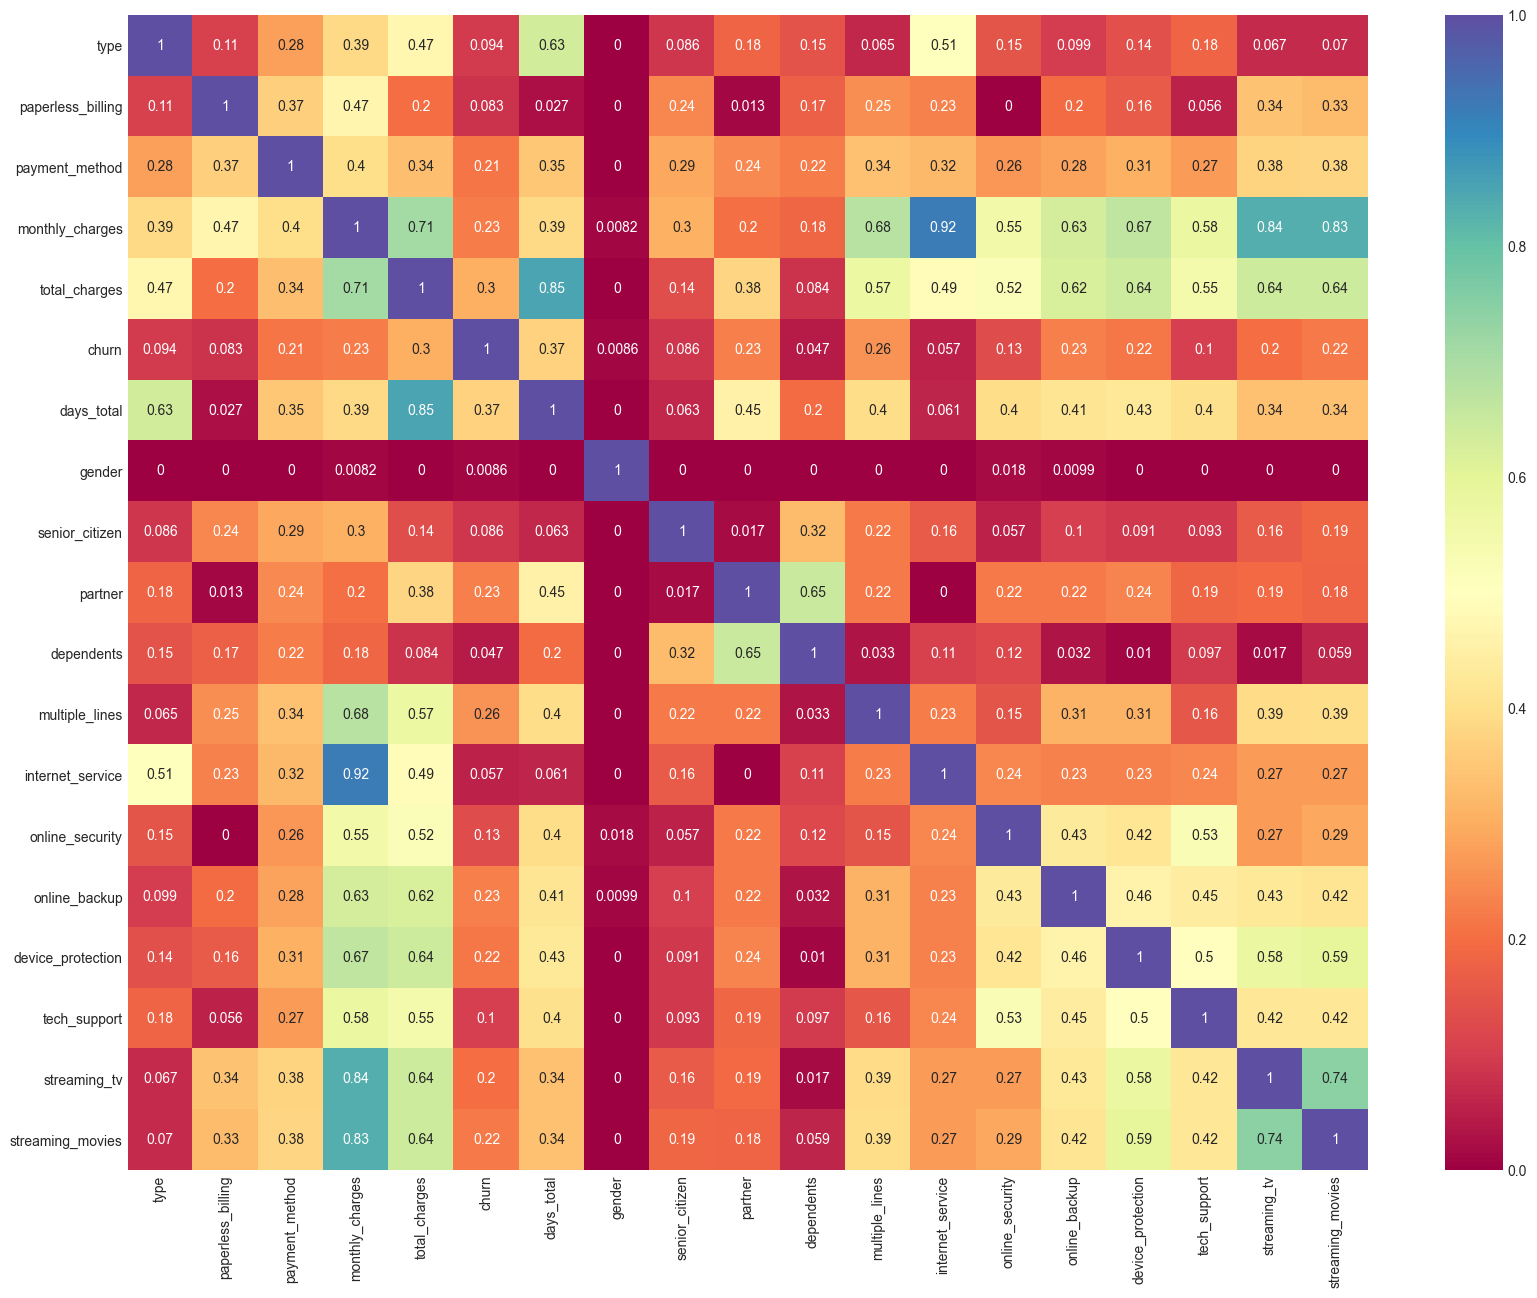

In [60]:
plt.figure(figsize=(20,15))
sns.heatmap(forsenuncorr.phik_matrix(interval_cols = interval_cols), cmap='Spectral', annot=True)

Наблюдается мультиколлениарность (0.82) между 'days_total' и 'total_charges', чем дольше клиент "является клиентом", тем больше он заплатит за всё время денег, логично. Также немного выделяется корреляция подключения услуг интернета, стримингового ТВ и фильмов и ежемесячного тарифа (0.92, 0.84, 0.83 соответственно), скорее всего, это самые дорогая услуга. Ещё есть некоторая корреляция между streaming_tv и streaming_movies (0.63), может быть, услуги идут в одном пакете, но особо нам это ничего не даёт. Ещё видим корреляцию между признаками замужества клиента и наличием иждивенцев (0.65), что тоже логично.

На основе выводов EDA, удалим следующие столбцы из датасета: total_charges, end_date, begin_date, gender.

In [61]:
forsenun.drop(columns=['begin_date', 'end_date', 'gender', 'total_charges'], inplace=True)
cat_features.remove('gender')
num_features.remove('total_charges')

In [62]:
information(forsenun)

Количество столбцов: 17
Количество строк: 7043
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   churn              7043 non-null   int32  
 5   days_total         7043 non-null   int64  
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   multiple_lines     7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv   

None

,type,paperless_billing,payment_method,monthly_charges,churn,days_total,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0,31,0,Yes,No,No,DSL,No,Yes,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,0,1036,0,No,No,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,0,123,0,No,No,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0,1371,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,0,153,0,No,No,No,Fiber optic,No,No,No,No,No,No


,monthly_charges,churn,days_total,senior_citizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,0.156325,898.555729,0.162147
std,30.090047,0.363189,683.130510,0.368612
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,0.000000,276.000000,0.000000
50%,70.350000,0.000000,761.000000,0.000000
75%,89.850000,0.000000,1461.000000,0.000000
max,118.750000,1.000000,2314.000000,1.000000


(None, None, None)

# Разбивка датасета на выборки для обучения моделей

In [63]:
features = forsenun.drop('churn', axis=1)
target = forsenun['churn']

In [64]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [65]:
print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))

Размер обучающей выборки: 5282 объектов, 16 признаков
Размер тестовой выборки: 1761 объектов, 16 признаков


Для Random Forest Regressor создадим два отдельных списка признаков для OHE и Ordinal Encoder, численные признаки обработаем для модели Catboost, ещё создадим категориальные признаки для модели LGBM.

In [66]:
ohe_features_rf = ['type',
 'payment_method',
 'senior_citizen',
 'internet_service'
 ]

In [67]:
oe_features_rf = ['paperless_billing',
 'partner',
 'dependents',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies']

In [68]:
features_train_rf = features_train.copy()
features_test_rf = features_test.copy()

In [69]:
features_train_numerical = features_train.copy()
features_test_numerical = features_test.copy()

In [70]:
#проведём масштабирование численных признаков
scaler = StandardScaler()
scaler.fit(features_train_numerical[num_features])

features_train_numerical[num_features] = scaler.transform(features_train_numerical[num_features])
features_test_numerical[num_features] = scaler.transform(features_test_numerical[num_features])

In [71]:
features_train_categorical = features_train.copy()

for column in features_train_categorical.columns:
    col_type = features_train_categorical[column].dtype
    if col_type == 'object' or column == 'senior_citizen':
        features_train_categorical[column] = features_train_categorical[column].astype('category')

features_test_categorical = features_test.copy()

for column in features_test_categorical.columns:
    col_type = features_test_categorical[column].dtype
    if col_type == 'object' or column == 'senior_citizen':
        features_test_categorical[column] = features_test_categorical[column].astype('category')

In [72]:
features_train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 9995-HOTOH to 8818-DOPVL
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5282 non-null   category
 1   paperless_billing  5282 non-null   category
 2   payment_method     5282 non-null   category
 3   monthly_charges    5282 non-null   float64 
 4   days_total         5282 non-null   int64   
 5   senior_citizen     5282 non-null   category
 6   partner            5282 non-null   category
 7   dependents         5282 non-null   category
 8   multiple_lines     5282 non-null   category
 9   internet_service   5282 non-null   category
 10  online_security    5282 non-null   category
 11  online_backup      5282 non-null   category
 12  device_protection  5282 non-null   category
 13  tech_support       5282 non-null   category
 14  streaming_tv       5282 non-null   category
 15  streaming_movies   5282 non-null   category
d

# Обучение моделей и кросс-валидация

**Random Forest Classifier**

С помощью пайплайна обучим модель случайного леса на кросс-валидации.

In [73]:
%%time

col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features_rf
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        oe_features_rf
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': range(10, 50, 100),
    'randomforestclassifier__max_depth': range(4, 21, 4),
    'randomforestclassifier__min_samples_leaf': range(1, 11, 1),
    'randomforestclassifier__class_weight' : [None, 'balanced']
}

#получается достаточно много комбинаций гиперпараметров при переборе
#будем использовать RandomizedSearchCV, он работает намного быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='roc_auc', 
    n_jobs=NJOBS, 
    random_state=RANDOM_STATE
)

gs_rf.fit(features_train_rf, target_train)

gs_rf_best_score = gs_rf.best_score_ 
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 0.8036875724077518
best_params: {'randomforestclassifier__n_estimators': 10, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__max_depth': 16, 'randomforestclassifier__class_weight': 'balanced'}
CPU times: total: 375 ms
Wall time: 1.13 s


Значение AUC_ROC лучшей обученной модели случайного леса: **0.8037** было достигнуто за **3,3 секунды**.

**Catboost Classifier**

Напишем функцию для кросс-валидации моделей с помощью RandomizedSearchCV c различными гиперпараметрами.

In [74]:
def train_model(model, parameters, features, target):
    
    model_random = RandomizedSearchCV(estimator=model,
                                      param_distributions=parameters, # используем параметры
                                      n_iter=ITERATIONS, 
                                      scoring='roc_auc', # используем необходимую метрику
                                      cv=CV, 
                                      verbose=VERBOSE, 
                                      random_state=RANDOM_STATE)
    
    # посмотрим время обучения 
    start = time()
    model_random.fit(features, target)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))

    # высчитаем метрики
    auc_roc = model_random.best_score_
    
    print('Лучшая модель:', model_random.best_estimator_)
    print('Лучшие параметры:', model_random.best_params_)
    print('AUC_ROC обученной модели:', auc_roc)
    
    return model_random.best_estimator_, auc_roc

In [75]:
parameters = {'depth': [6, 8, 10],
              'learning_rate': [0.01, 0.1, 0.5, 1],
              'iterations': [100, 200, 400]
              }

cat = CatBoostClassifier(verbose=False, task_type='CPU', cat_features=cat_features)

cat_random, auc_cat = train_model(cat, parameters, features_train, target_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RandomizedSearchCV подбирал параметры 2717.73 секунд
Лучшая модель: <catboost.core.CatBoostClassifier object at 0x0000017345388160>
Лучшие параметры: {'learning_rate': 0.1, 'iterations': 400, 'depth': 6}
AUC_ROC обученной модели: 0.9076658367932486


Значение AUC_ROC лучшей обученной модели Catboost: **0.9077** было достигнуто за **~22 минуты**.

**LGBM Classifier**

In [76]:
%%time

rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25],
    'learning_rate': [0.01, 0.1, 0.15],
    'num_leaves': [10, 50, 100]
}

gbm = LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc_roc')

gbm_random, auc_gbm = train_model(gbm, rand_lgbm_param, features_train_categorical, target_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Number of positive: 656, number of negative: 3569
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.155266 -> initscore=-1.693880
[LightGBM] [Info] Start training from score -1.693880
[LightGBM] [Info] Number of positive: 656, number of negative: 3569
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train

Значение AUC_ROC лучшей обученной модели LGBM Classifier: **0.8902** было достигнуто за **~2 минуты**.

# Анализ моделей

In [77]:
result = pd.DataFrame(
    [gs_rf_best_score, auc_cat, auc_gbm], 
    index=['RandomForestClassifier', 'Catboost', 'LGBM'], 
    columns=['AUC_ROC']
)
result

,AUC_ROC
RandomForestClassifier,0.803688
Catboost,0.907666
LGBM,0.890181


Модель случайного леса быстрее всего подбирает гиперпараметры и обучается. AUC_ROC модели - 0.8037. Catboost на это потребовалось целых 24 минуты, но метрика оказалась наилучшей - 0.9077. LightGBM справилась за ~2 минуты. Метрика AUC_ROC оказалась на втором месте после случайного леса - 0.8902. Далее проверим качество лучшей модели Catboost на тестовой выборке.

# Тестирование лучшей модели

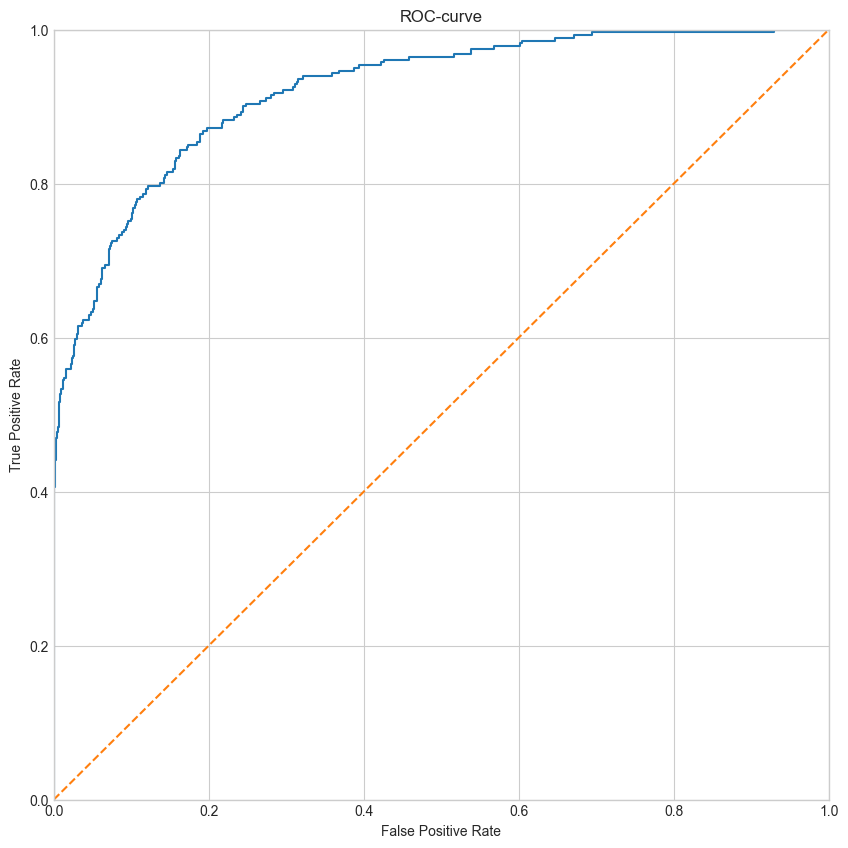

AUC: 0.9207992690199096
accuracy: 0.9136854060193073
CPU times: total: 234 ms
Wall time: 335 ms


In [78]:
%%time

y_pred = cat_random.predict(features_test)
accuracy = accuracy_score(target_test, y_pred)
AUC_ROC = roc_auc_score(target_test, cat_random.predict_proba(features_test)[:,1])


probabilities_one_valid = cat_random.predict_proba(features_test)[:,1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print("AUC:", auc_roc)
print("accuracy:", accuracy)



In [79]:
matrix = confusion_matrix(target_test, y_pred, normalize='true')

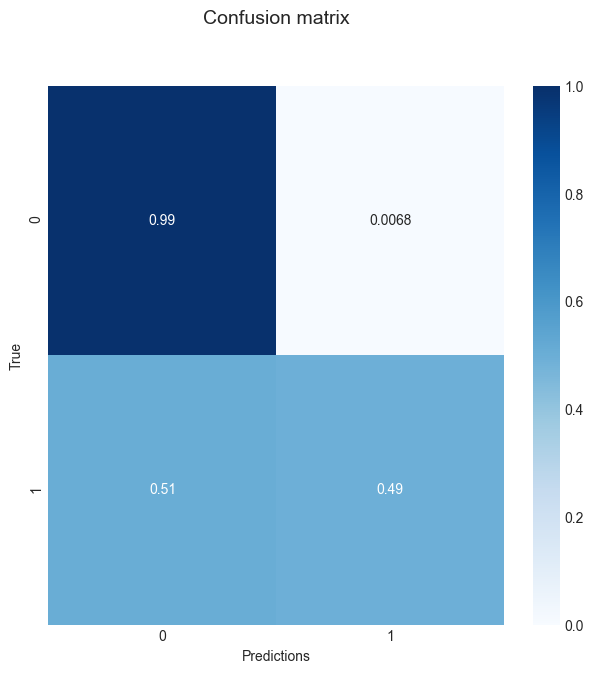

In [80]:
plt.figure(figsize=(25, 7))
ax = plt.subplot(1, 3, 1)

sns.heatmap(matrix, annot=True, cmap='Blues', vmin=0, vmax=1, ax=ax)

ax.set(xlabel='Predictions', ylabel='True')

plt.title('Confusion matrix', fontsize=14, y=1.1)
plt.show()

Модель CatBoostClassifier хорошо предсказывает отрицательный класс (факт того, что клиент остался), однако не очень хорошо предсказывает уход клиента и часто дает ложноположительные ответы. В то же время у CatBoostClassifier очень высокая точность.

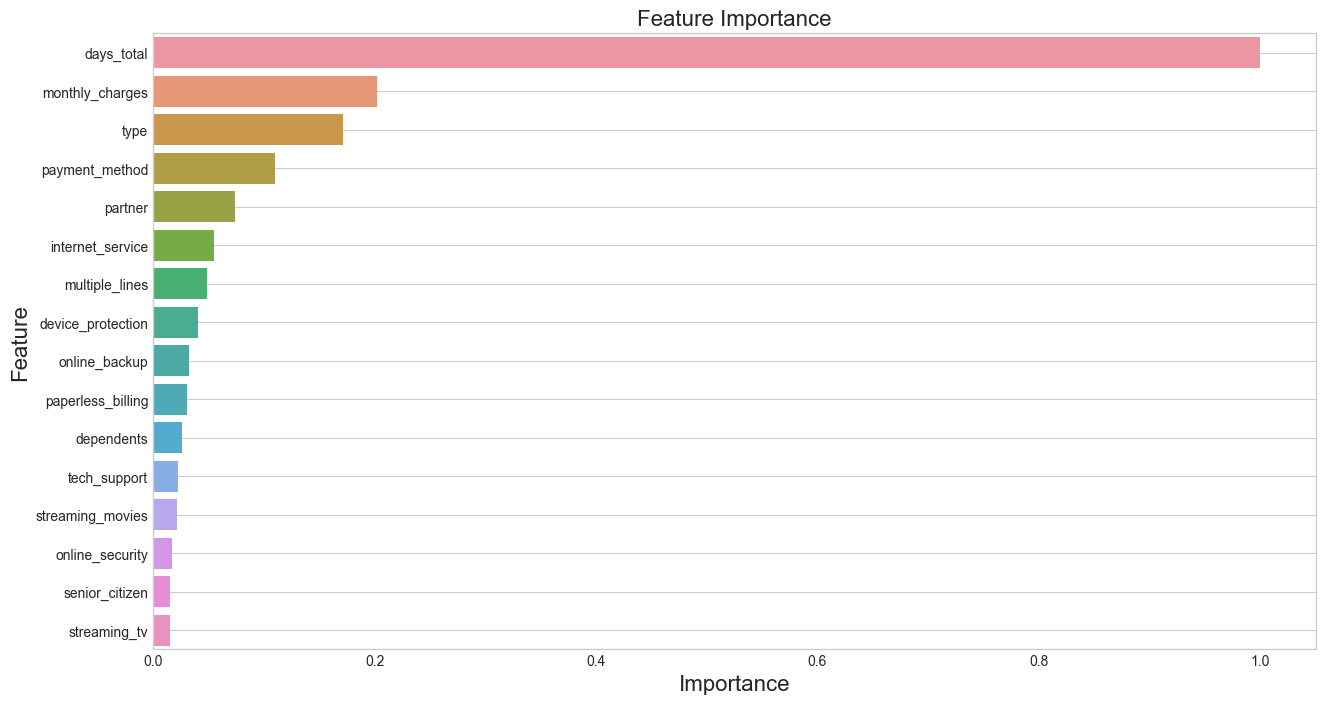

In [81]:
feature_importance = pd.Series(cat_random.feature_importances_,
                               index=features_test.columns)
feature_importance = (feature_importance/feature_importance.max()).sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.grid()
plt.show()

Самый важный признак - время действия договора. Его значимость почти в 5 раз выше, чем у величины ежемесячной платы, которая идёт на втором месте. На третьем месте у нас тип оплаты: ежемесячный, годовой и т.д.  
На четвертом месте способ оплаты, а замыкает пятёрку фактор наличия супруга.  
Остальные признаки имеют куда меньшую значимость.

В итоге на тестовой выборке AUC_ROC наилучшей модели Catboost **0.9208**, точность - 0.9137, время предсказания менее секунды.  
**Удалось преодолеть минимально требуемое значение метрики AUC-ROC в 0.85 и даже значительно превзойти его, условие выполнено.**

# Итоговый вывод

Проанализирована работа нескольких моделей для предсказания оттока клиентов по предоставленным данным.

Для достижения целей минимизации рисков на траты бюджета для промоакций для клиентов, которые не собираются уходить, а также своевременно спрогнозировать уход того или иного клиента необходима модель с минимальными ложно-положительными и ложно-отрицательными предсказаниями. Из рассмотренных моделей - CatBoostClassifier подойдёт очень даже неплохо, ведь она очень хорошо справляется с предсказаниями клиентов, которые не собираются уходить, однако не очень хорошо предсказывает случаи, когда тот или иной клиент намеревается уйти.

Проведя анализ данных и исходя из сделанных из него выводов, можно заметить, что скорее всего, большая часть клиентов уходит из-за высокой стоимости услуг. Факт ухода не зависит от гендерной принадлежности клиента.   
Во время планирования промоакций рекомендуется сделать упор на более молодых клиентов, клиентов с оптоволоконным подключением к интернету и клиентов, которые ежемесячно оплачивают услуги.

Очень большая часть клиентов уходит в первые месяцы подключения, это следует учитывать при проведении специальных акций и раздач промокодов.